In [1]:
import os
import sys
code_dir = os.path.split(os.getcwd())[0]
if code_dir not in sys.path:
    sys.path.append(code_dir)

In [2]:
import numpy as np
import pickle

from contrastive_divergence_optimiser import CDOptimiser
from distribution import RBMLatentPosterior, MultivariateBernoulliNoise, ChowLiuTree
from fully_observed_models import VisibleRestrictedBoltzmannMachine
from latent_variable_model import RestrictedBoltzmannMachine
from nce_optimiser import NCEOptimiser
from utils import plot_log_likelihood_training_curves, takeClosest, create_J_diff_plot, get_Js_for_vnce_thetas
from vnce_optimisers import VNCEOptimiser

from copy import deepcopy
from matplotlib import pyplot as plt
from matplotlib import rc
from numpy import random as rnd

%matplotlib inline
rc('lines', linewidth=1.5)
rc('font', size=18)
rc('legend', fontsize=16)
rc('text', usetex=True)
rc('xtick', labelsize=18)
rc('ytick', labelsize=18)

# For reproducibility
rng = rnd.RandomState(1083463236)

In [3]:
exp_name = 'usps'  # CHANGE ME
model_name = 'rbm'  # CHANGE ME
skip_files = []

In [4]:
exp_res_dir = '/afs/inf.ed.ac.uk/user/s17/s1771906/masters-project/ben-rhodes-masters-project/experimental-results/' + model_name
save_res_dir = '/afs/inf.ed.ac.uk/user/s17/s1771906/masters-project/ben-rhodes-masters-project/proposal/experiments/' + model_name
exp_dir = os.path.join(exp_res_dir, exp_name)
save_dir = os.path.join(save_res_dir, exp_name)

if not os.path.exists(save_dir):
    os.makedirs(save_dir)

## plot J & LL

In [5]:
def sanity_check_stats(J1s, Js_for_vnce_thetas, file):
    stats ='file: {0}. Percentage of iters for which J1 increases: {1:.4g}%\n          Percentage of iters for which J increases: {2:.4g}%\n          Percentage of iters for which J1 is less than J: {3:.4g}%\n'.format(file, 
    100* np.sum(np.array([J1a < J1b for J1a, J1b in zip(J1s[:-1], J1s[1:])])) / (len(J1s)-1),
    100*np.sum(np.array([Ja < Jb for Ja, Jb in zip(Js_for_vnce_thetas[:-1], Js_for_vnce_thetas[1:])])) / (len(Js_for_vnce_thetas)-1),
    100*np.mean(J1s < Js_for_vnce_thetas))
    
    return stats

In [6]:
def annotate(ax, annotation, xy, length=100):
    ax.annotate(annotation, xy=xy, xycoords='data', xytext=(length, length), textcoords="offset points", 
        arrowprops=dict(facecolor='black', shrink=0.03), horizontalalignment='right', 
        verticalalignment='bottom', fontsize=16)

In [7]:
def plot_and_annotate(ax, times, vals, annotation, annotate_val, length=100):
    ax.semilogx(times, vals)
    ind = takeClosest(vals, annotate_val)
    annotate(ax, annotation, (times[ind], vals[ind]), length)
    ax.annotate(r"{}".format(round(vals[-1], 4)), xy=(times[-1], vals[-1]), fontsize=12)

NameError: name 'true_theta' is not defined

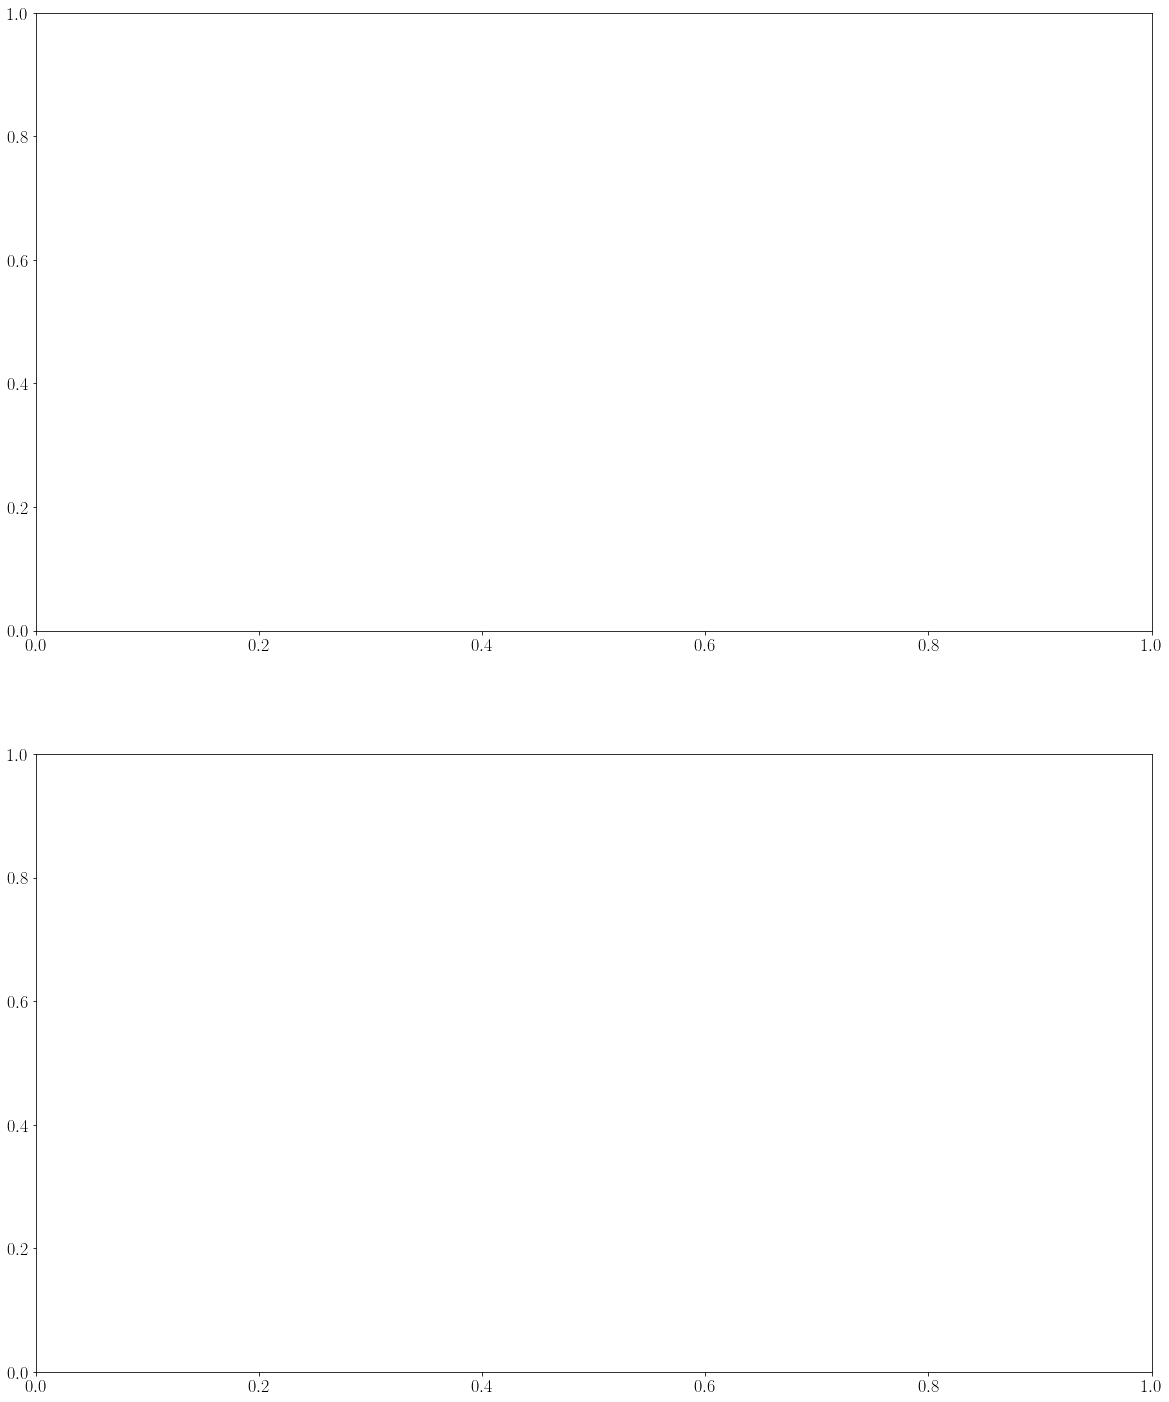

In [9]:
# CHANGE ME
arrow_y_val = 0
arrow_y_val_2 = 0
arrow_y_val_3 = -2.22 # log-like plot vnce
arrow_y_val_4 = 0 # log-like plot cd

fig, axs = plt.subplots(2, 1, figsize=(20, 25))
axs = axs.ravel()
#sorted_files = [str(file) for file in sorted([int(file) for file in os.listdir(exp_dir)])]
for i, file in enumerate(os.listdir(exp_dir)):
    exp = os.path.join(exp_dir, file)
    
    if file in skip_files:
        continue
    ######## LOAD EVERYTHING FROM FILE #########
    config = pickle.load(open(os.path.join(exp, 'config.p'), 'rb'))
    
    loaded_data = np.load(os.path.join(exp, 'data.npz'))
    loaded_init = np.load(os.path.join(exp, 'init_theta_and_likelihood.npz'))
    loaded_vnce = np.load(os.path.join(exp, 'vnce_results.npz'))
    loaded_cd = np.load(os.path.join(exp, 'cd_results.npz'))
    loaded_nce = np.load(os.path.join(exp, 'nce_results.npz'))
    
    X = loaded_data['X']
    Y = loaded_data['Y']
    
    theta0 = loaded_init['theta0']
    init_log_like = loaded_init['ll']
    
    J1s = loaded_vnce['J1s']
    vnce_thetas = loaded_vnce['params']
    vnce_times = loaded_vnce['times']
    vnce_reduced_times = loaded_vnce['reduced_times']
    av_log_like_vnce = loaded_vnce['ll']
    
    cd_times = loaded_cd['times']
    cd_reduced_times = loaded_cd['reduced_times']
    av_log_like_cd = loaded_cd['ll']
    
    Js = loaded_nce['Js']
    Js_for_vnce_thetas = loaded_nce['Js_for_vnce_thetas']
    nce_times = loaded_nce['times']
    nce_reduced_times = loaded_nce['reduced_times']
    av_log_like_nce = loaded_nce['ll']
    
    rng = np.random.RandomState(config['random_seed'])
    
    # reconstruct models & optimisers
    model = RestrictedBoltzmannMachine(deepcopy(theta0), rng=rng)
    nce_model = VisibleRestrictedBoltzmannMachine(deepcopy(theta0), rng=rng)
    
    var_dist = RBMLatentPosterior(theta0, rng=rng)
    
    noise = MultivariateBernoulliNoise(np.mean(X, axis=0))
    noise_log_like = np.mean(np.log(noise(X)))
    
    optimiser = VNCEOptimiser(model=model, noise=noise, variational_dist=var_dist, noise_samples=Y, 
                              nu=config['nu'], latent_samples_per_datapoint=config['nz'], rng=rng)
    nce_optimiser = NCEOptimiser(model=nce_model, noise=noise, noise_samples=Y, nu=config['nu'])
    
    optimal_J1 = optimiser.evaluate_J1_at_param(theta=true_theta.reshape(-1), X=X)
    optimal_J = nce_optimiser.evaluate_J_at_param(true_theta.reshape(-1), X)
    
    if J1s.ndim == 2:
        J1s = np.sum(J1s, axis=1)
        Js_for_vnce_thetas = np.sum(Js_for_vnce_thetas, axis=1)
    
    ####### ACTUAL PLOTTING ###########
    if i == 0:
        arrow_y_val = optimal_J - 0.05
        arrow_y_val_2 = optimal_J - 0.05
        arrow_y_val_3 = noise_log_like + ((true_log_like - noise_log_like)/2) + 0.02 # log-like plot vnce
        arrow_y_val_4 = noise_log_like + ((true_log_like - noise_log_like)/2) + 0.01  # log-like plot cd
    arrow_length = length=30 + (20*i)
    
    # NCE OBJECTIVE PLOT
    ax = axs[0]
    #plot_and_annotate(ax, vnce_times, J1s, r"J1 {}".format(file), arrow_y_val, length=20*i)
    #arrow_y_val -= 0.01    
    plot_and_annotate(ax, vnce_times, Js_for_vnce_thetas, r"J {}".format(file), arrow_y_val_2, length=arrow_length)
    arrow_y_val_2 -= 0.05
    ax.set_xlabel('time (seconds)', fontsize=18)
    ax.set_ylabel('J1', fontsize=18)
    
    # LOG-LIKELIHOOD PLOT
    ax = axs[1]
    plot_and_annotate(ax, cd_reduced_times, av_log_like_cd, "CD {}".format(config['cd_learn_rate']), 
                      arrow_y_val_4, length=arrow_length)
    arrow_y_val_4 -= 0.01
    plot_and_annotate(ax, vnce_reduced_times, av_log_like_vnce, "VNCE {}".format(file), arrow_y_val_3, length=arrow_length)
    arrow_y_val_3 -= 0.01
    
    ax.set_xlabel('time (seconds)', fontsize=18)
    ax.set_ylabel('log likelihood', fontsize=18)
    
    if i == 0:
        ax = axs[0]
        plot_and_annotate(ax, nce_times, Js, "J", arrow_y_val)
        
        ax = axs[1]  
        plot_and_annotate(ax, nce_reduced_times, av_log_like_nce, "NCE", arrow_y_val_3)  
        ax.plot((0, plt.get(ax, 'xlim')[1]), (noise_log_like, noise_log_like),'g--', label='Noise distribution')
        ax.plot((0, plt.get(ax, 'xlim')[1]), (init_log_like, init_log_like),'r--', label='initial model')
        ax.plot((0, plt.get(ax, 'xlim')[1]), (true_log_like, true_log_like),'b--', label='True distribution')
    
    stats = sanity_check_stats(J1s, Js_for_vnce_thetas, file)     
    if i == 0:
        with open(os.path.join(save_dir, 'vnce_sanity_check.txt'), 'w') as f:
            f.write(stats)
    else:
        with open(os.path.join(save_dir, 'vnce_sanity_check.txt'), 'a') as f:
            f.write(stats)
            
    with open(os.path.join(save_dir, "config-{}.txt".format(file)), 'w') as f:
        for key, value in config.items():
            f.write("{}: {}\n".format(key, value))
            

axs[0].set_xlim(1e-2, axs[0].get_xlim()[1])
axs[0].set_ylim((optimal_J1 - 0.2, optimal_J1 + 0.1))

axs[1].set_xlim(1e-2, axs[1].get_xlim()[1])
axs[1].set_ylim((noise_log_like-0.03, true_log_like + 0.005))

axs[0].legend(loc='lower right')
axs[1].legend(loc='lower right')

fig.savefig(os.path.join(save_dir, 'best_models_comparison.pdf'))

## plot two terms of J1/J separately

In [ ]:
#sorted_files = [str(file) for file in sorted([int(file) for file in os.listdir(exp_dir)])]
for i, file in enumerate(os.listdir(exp_dir)):
    exp = os.path.join(exp_dir, file)
    
    if file in skip_files:
        continue
    ######## LOAD EVERYTHING FROM FILE #########
    config = pickle.load(open(os.path.join(exp, 'config.p'), 'rb'))
    
    loaded_data = np.load(os.path.join(exp, 'data.npz'))
    loaded_truth = np.load(os.path.join(exp, 'true_weights_and_likelihood.npz'))
    loaded_init = np.load(os.path.join(exp, 'init_theta_and_likelihood.npz'))
    loaded_vnce = np.load(os.path.join(exp, 'vnce_results.npz'))
    loaded_nce = np.load(os.path.join(exp, 'nce_results.npz'))
    loaded_true = np.load(os.path.join(exp, 'true_weights_and_likelihood.npz'))
    
    X = loaded_data['X']
    Y = loaded_data['Y']
    
    true_theta = loaded_truth['true_theta']
    true_log_like = loaded_truth['ll']
    
    theta0 = loaded_init['theta0']
    init_log_like = loaded_init['ll']
    
    E_step_ids = loaded_vnce['E_step_ids']
    J1s = loaded_vnce['J1s']
    J1s_1 = J1s[:, 0]
    J1s_2 = J1s[:, 1]
    vnce_thetas = loaded_vnce['params']
    vnce_times = loaded_vnce['times']
    vnce_reduced_times = loaded_vnce['reduced_times']
    av_log_like_vnce = loaded_vnce['ll']
    
    Js = loaded_nce['Js']
    Js_for_vnce_thetas = loaded_nce['Js_for_vnce_thetas']
    nce_times = loaded_nce['times']
    nce_reduced_times = loaded_nce['reduced_times']
    av_log_like_nce = loaded_nce['ll']
    
    # reconstruct models & optimisers
    model = RestrictedBoltzmannMachine(deepcopy(theta0), rng=rng)
    nce_model = VisibleRestrictedBoltzmannMachine(deepcopy(theta0), rng=rng)
    
    var_dist = RBMLatentPosterior(theta0, rng=rng)
    
    noise = MultivariateBernoulliNoise(np.mean(X, axis=0))
    noise_log_like = np.mean(np.log(noise(X)))
    
    optimal_J1 = optimiser.evaluate_J1_at_param(theta=true_theta.reshape(-1), X=X)
    optimal_J = nce_optimiser.evaluate_J_at_param(true_theta.reshape(-1), X)
    
    ####### ACTUAL PLOTTING ###########
    if config['optimiser'] == 'VNCEOptimiserWithoutImportanceSampling':
        J_plot, _ = create_J_diff_plot(J1s, vnce_times, E_step_ids, Js_for_vnce_thetas, 
                                       posterior_ratio_vars=None, plot_posterior_ratio=False)
        axs = J_plot.axes
        axs[0].set_xlim(-5, 20)
        axs[0].set_ylim((-0.02, 0.02))
    else:
        J_plot, _ = create_J_diff_plot(J1s, vnce_times, E_step_ids, Js_for_vnce_thetas, 
                                       posterior_ratio_vars=None, plot_posterior_ratio=False)
        axs = J_plot.axes
        axs[0].set_xlim(-5, 20)
        axs[0].set_ylim((-0.02, 0.02))
        #axs[1].set_xlim(-5, 100)
        #axs[1].set_ylim((0, 0.1))
        
    J_plot.suptitle('{}'.format(file))
    
#     ind1 = int(len(J1s_1)/2)
#     ind2 = int(len(J1s_2)/3)
#     annotate(ax, r"term1 J1 {}".format(file), (vnce_times[ind1], J1s_1[ind1]))
#     annotate(ax, r"term2 J1 {}".format(file), (vnce_times[ind2], J1s_2[ind2]))
        
    #axs[0].set_xlim((0, 1e1))
    
    J_plot.set_size_inches(15, 15)

    J_plot.savefig(os.path.join(save_dir, 'two-terms-of-J1-{}.pdf'.format(file)))

In [ ]:
test_array = np.zeros((100,100,100))*1e-7 - np.zeros((100,100,100))*1e-8
np.isnan(test_array).any()

## Plot J (not LL)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(15, 15))

#sorted_files = [str(file) for file in sorted([int(file) for file in os.listdir(exp_dir)])]
for i, file in enumerate(os.listdir(exp_dir)):
    exp = os.path.join(exp_dir, file)
    
    optimiser = pickle.load(open(os.path.join(exp, 'lnce_optimiser.p'), 'rb'))
    nce_optimiser = pickle.load(open(os.path.join(exp, 'nce_optimiser.p'), 'rb'))
    
    loaded_data = np.load(os.path.join(exp, 'data.npz'))
    loaded_lnce = np.load(os.path.join(exp, 'lnce_results.npz'))
    loaded_cd = np.load(os.path.join(exp, 'cd_results.npz'))
    loaded_nce = np.load(os.path.join(exp, 'nce_results.npz'))
    loaded_true = np.load(os.path.join(exp, 'true_weights_and_likelihood.npz'))
    
    X = loaded_data['X']
    Y = loaded_data['Y']
    true_theta = loaded_true['true_theta']
    
    lnce_thetas = loaded_lnce['params']
    J1s = loaded_lnce['J1s']
    lnce_times = loaded_lnce['times']
    
    nce_thetas = loaded_nce['params']
    Js = loaded_nce['Js']
    Js_for_lnce_thetas = loaded_nce['Js_for_lnce_thetas']
    nce_times = loaded_nce['times']

    ax.plot(lnce_times, J1s, label='Latent NCE {}'.format(file))
    ax.annotate(r"J1 {}".format(file), xy=(lnce_times[-1], J1s[-1]), fontsize=14, weight='bold')
    
    ax.plot(lnce_times, Js_for_lnce_thetas, label='J evaluated at J1 params')
    ax.annotate(r"J {}".format(file), xy=(lnce_times[-1], Js_for_lnce_thetas[-1]), fontsize=14,weight='bold')

ax.plot(nce_times, Js, label='J')
ax.annotate(r"J".format(file), xy=(nce_times[-1], Js[-1]), fontsize=14, weight='bold')

optimal_J1 = optimiser.evaluate_J1_at_param(theta=true_theta.reshape(-1), X=X)
ax.plot((lnce_times[0], lnce_times[-1]), (optimal_J1, optimal_J1), label=r'J1($\theta_{true}$)')

optimal_J = nce_optimiser.evaluate_J_at_param(true_theta.reshape(-1), X)
ax.plot((lnce_times[0], lnce_times[-1]), (optimal_J, optimal_J), label=r'J($\theta_{true}$)')

ax.set_xlabel('time (seconds)', fontsize=16)
ax.set_ylabel('J1', fontsize=16)
ax.set_ylim((-1.175, -1.10))
#ax.set_xlim((0, 50))
ax.legend()
_ = ax.legend(loc='lower right')


#fig.savefig(os.path.join(save_dir, 'partial-mstep-comparison_Js.pdf'))